# Coursework 2 - PyTorch based experiment framework

## Intro
Welcome to the coursework 2 PyTorch experiment framework. Pytorch is a  modern, intuitive, highly Pythonic and very fast framework for building differentiable graphs. Neural networks, as it happens, are a type of acyclic differentiable graph, so PyTorch is a great framework to use, if you want to build  complicated deep networks fairly easily.

## MLP package vs Pytorch
**Student**: So, why do I have to learn to use PyTorch now? I've spent all this time working on the MLP framework. Was that a waste of time?

**TA**: Well, Pytorch is everything the MLP package is, but faster, cleaner and far more resourceful. Since it is one of the main deep learning frameworks being used by industry and research alike, it has been fine-tuned quite a bit, to conform to the expectation of researchers and engineers alike. What this means, is that PyTorch is now a very robust and highly flexible package, that you can use for any project you want to work on in the future, if it involves trainining differentiable graphs. 

In addition, MLP is written in NumPy and your time working on it has taught some low level details of NNs; PyTorch was written to look as much as possible to NumPy, so it will feel very familiar to you. The skills you have acquired are highly transferable (that is, they generalize well, so not much overfitting there...). 

PyTorch will almost always have all the latest and greatest implemented in it as soon as they are released as papers, and if not, give it a week or two and someone will reproduce it. If you can't wait, you can reproduce it yourself and open source it. A great way to show your skills and get github likes. 

In addition PyTorch has Autograd! Automatic differentiation (previously mentioned in [lectures](http://www.inf.ed.ac.uk/teaching/courses/mlp/2018-19/mlp05-learn.pdf)). "What is this?" you may ask. Remember having to write all those backprop functions? Forget about it. Automatic differentiation allows you to backprop through any PyTorch operation you have used in your graph, by simply calling backward(). This [blog-post](https://jdhao.github.io/2017/11/12/pytorch-computation-graph/) explains how Pytorch's autograd works at an intuitive level.

**Student**: Why did we even have to use the MLP package? We did we even bother if such awesome frameworks are available?

**TA**: The purpose of the MLP package was not to allow you to build fast deep learning systems. Instead, it was to help teach you the low level mechanics and sensitivities of building a deep learning system. It allowed you to delve deep into how one can go about building a deep learning framework from scratch. The intuitions you have gained from going through your assignments and courseworks allow you to see deeper in what makes or breaks a deep learning system, at a level few people actually have. You are no longer restricted to the higher level modules provided by Pytorch/TensorFlow. 

If, for example, a new project required you to build something that does not exist in PyTorch/TensorFlow, or otherwise modify existing modules in a way that requires understanding and intuitions on backpropagation and layer/optimizer/component implementation, you would be able to do it much more easily than others who did not. You are now equipped to understand differentiable graphs, the chain rule, numerical errors, debugging at the lowest level and deep learning system architecture. 

In addition, by trying to implement your modules in an efficient way, you have also become aware of how to optimize a system for efficiency, and gave you intuitions on how one could further improve such a system (parallelization of implementations). 

Finally, the slowness of CPU training has allowed you to understand just how important modern GPU acceleration is, for deep learning research and applications. By coming across a large breadth of problems and understanding their origins, you will now be able to both anticipate and solve future problems in a more comprehensive way than someone who did not go through the trouble of implementing the basics from scratch. 

**Student**: If we are switching to Pytorch, then why bother implementing convolutions in the MLP package for the coursework?

**TA**: All your instructors, myself included, have found it greatly beneficial to implement convolutional networks from scratch. Once you implement convolutional layers, you will have a much deeper insight and understanding into how and why they work... as well as how they break. This way, you know what to do and what to avoid in the future. You might even be able to come with the next great network type yourself. 


## Getting Started

**Student**: So, how is the learning curve of Pytorch? How do I start?

**TA**: You can start by using this notebook on your experiments, it should teach you quite a lot on how to properly use PyTorch for basic conv net training. You should be aware of the [official pytorch github](https://github.com/pytorch/pytorch), the [pytorch official documentation page](https://pytorch.org/docs/stable/nn.html) and the [pytorch tutorials page](https://pytorch.org/tutorials/). 

Over the past year, nearly all students using PyTorch and Tensorflow on MLP and on projects found it easier and faster to get up to speed with PyTorch. In fact, I was a TensorFlow user myself, and learning TensorFlow was much more challenging than PyTorch. Mainly because TensorFlow has its own way of 'thinking' about how you build a graph and execute operations - whereas PyTorch is dynamic and works like NumPy, hence is more intuitive. If you were able to work well with the MLP package, you'll be up and running in no time. 

**Student**: OK, so how fast is pytorch compared to MLP?

**TA**: On the CPU side of things, you'll find pytorch at least 5x faster than the MLP framework (about equal for fully connected networks, but much faster for more complicated things like convolutions - unless you write extremely efficient convolutional layer code), and if you choose to use GPUs, either using MS Azure, Google Cloud or our very own MLP Cluster (available for next semester), you can expect, depending on implementation and hardware an approximate 25-70x speed ups, compared to the CPU performance of pytorch. Yes, that means an experiment that would run overnight, now would only require about 15 minutes.

**Student**: Ahh, where should I go to ask more questions?

**TA**: As always, start with a Google/DuckDuckGo search, then have a look at the PyTorch Github and PyTorch docs, and if you can't find the answer come to Piazza and the lab sessions. We will be there to support you.


#### Note: The code in this jupyter notebook is to introduce you to pytorch and allow you to play around with it in an interactive manner. However, to run your experiments, you should use the Pytorch experiment framework located in ```mlp/pytorch_experiment_scripts```. Instructions on how to use it can be found in ```notes/pytorch-experiment-framework.md``` along with the comments and documentation included in the code itself.

In [1]:
from torch import nn
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import tqdm
import os
import mlp.data_providers as data_providers
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def plot_stats_in_graph(total_losses):
    
    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in total_losses.keys():
        if "loss" in k:
            ax_1.plot(np.arange(len(total_losses[k])), total_losses[k], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    
    
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in total_losses.keys():
        if "acc" in k:
            ax_2.plot(np.arange(len(total_losses[k])), total_losses[k], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')

    plt.show()

In [3]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self, input_shape, dim_reduction_type, num_output_classes, num_filters, num_layers, use_bias=False):
        """
        Initializes a convolutional network module object.
        :param input_shape: The shape of the inputs going in to the network.
        :param dim_reduction_type: The type of dimensionality reduction to apply after each convolutional stage, should be one of ['max_pooling', 'avg_pooling', 'strided_convolution', 'dilated_convolution']
        :param num_output_classes: The number of outputs the network should have (for classification those would be the number of classes)
        :param num_filters: Number of filters used in every conv layer, except dim reduction stages, where those are automatically infered.
        :param num_layers: Number of conv layers (excluding dim reduction stages)
        :param use_bias: Whether our convolutions will use a bias.
        """
        super(ConvolutionalNetwork, self).__init__()
        # set up class attributes useful in building the network and inference
        self.input_shape = input_shape
        self.num_filters = num_filters
        self.num_output_classes = num_output_classes
        self.use_bias = use_bias
        self.num_layers = num_layers
        self.dim_reduction_type = dim_reduction_type
        # initialize a module dict, which is effectively a dictionary that can collect layers and integrate them into pytorch
        self.layer_dict = nn.ModuleDict()
        # build the network
        self.build_module()

    def build_module(self):
        """
        Builds network whilst automatically inferring shapes of layers.
        """
        print("Building basic block of ConvolutionalNetwork using input shape", self.input_shape)
        x = torch.zeros((self.input_shape)) # create dummy inputs to be used to infer shapes of layers

        out = x
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        for i in range(self.num_layers): # for number of layers times
            self.layer_dict['conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1], # add a conv layer in the module dict
                                                             kernel_size=3,
                                                             out_channels=self.num_filters, padding=1,
                                                             bias=self.use_bias)

            out = self.layer_dict['conv_{}'.format(i)](out) # use layer on inputs to get an output
            out = F.relu(out) # apply relu
            print(out.shape)
            if self.dim_reduction_type == 'strided_convolution': # if dim reduction is strided conv, then add a strided conv
                self.layer_dict['dim_reduction_strided_conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                                                       kernel_size=3,
                                                                                       out_channels=out.shape[1],
                                                                                       padding=1,
                                                                                       bias=self.use_bias, stride=2,
                                                                                       dilation=1)

                out = self.layer_dict['dim_reduction_strided_conv_{}'.format(i)](out) # use strided conv to get an output
                out = F.relu(out) # apply relu to the output
            elif self.dim_reduction_type == 'dilated_convolution': # if dim reduction is dilated conv, then add a dilated conv, using an arbitrary dilation rate of i + 2 (so it gets smaller as we go, you can choose other dilation rates should you wish to do it.)
                self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                                                       kernel_size=3,
                                                                                       out_channels=out.shape[1],
                                                                                       padding=1,
                                                                                       bias=self.use_bias, stride=1,
                                                                                       dilation=i + 2)
                out = self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)](out) # run dilated conv on input to get output
                out = F.relu(out) # apply relu on output

            elif self.dim_reduction_type == 'max_pooling':
                self.layer_dict['dim_reduction_max_pool_{}'.format(i)] = nn.MaxPool2d(2, padding=1)
                out = self.layer_dict['dim_reduction_max_pool_{}'.format(i)](out)

            elif self.dim_reduction_type == 'avg_pooling':
                self.layer_dict['dim_reduction_avg_pool_{}'.format(i)] = nn.AvgPool2d(2, padding=1)
                out = self.layer_dict['dim_reduction_avg_pool_{}'.format(i)](out)

            print(out.shape)

        out = F.adaptive_avg_pool2d(out, 2) # apply adaptive pooling to make sure output of conv layers is always (2, 2) spacially (helps with comparisons).
        print(out.shape)
        self.logits_linear_layer = nn.Linear(in_features=out.view(out.shape[0], -1).shape[1],  # add a linear layer
                                             out_features=self.num_output_classes,
                                             bias=self.use_bias)
        out = self.logits_linear_layer(out.view(out.shape[0], -1)) # apply linear layer on flattened inputs
        print("Block is built, output volume is", out.shape)
        return out

    def forward(self, x):
        """
        Forward propages the network given an input batch
        :param x: Inputs x (b, c, h, w)
        :return: preds (b, num_classes)
        """
        out = x
        for i in range(self.num_layers): # for number of layers

            out = self.layer_dict['conv_{}'.format(i)](out) # pass through conv layer indexed at i
            out = F.relu(out) # pass conv outputs through ReLU
            if self.dim_reduction_type == 'strided_convolution': # if strided convolution dim reduction then
                out = self.layer_dict['dim_reduction_strided_conv_{}'.format(i)](out) # pass previous outputs through a strided convolution indexed i
                out = F.relu(out) # pass strided conv outputs through ReLU

            elif self.dim_reduction_type == 'dilated_convolution':
                out = self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)](out)
                out = F.relu(out)

            elif self.dim_reduction_type == 'max_pooling':
                out = self.layer_dict['dim_reduction_max_pool_{}'.format(i)](out)

            elif self.dim_reduction_type == 'avg_pooling':
                out = self.layer_dict['dim_reduction_avg_pool_{}'.format(i)](out)

        out = F.adaptive_avg_pool2d(out, 2)
        out = out.view(out.shape[0], -1) # flatten outputs from (b, c, h, w) to (b, c*h*w)
        out = self.logits_linear_layer(out) # pass through a linear layer to get logits/preds
        return out

    def reset_parameters(self):
        """
        Re-initialize the network parameters.
        """
        for item in self.layer_dict.children():
            try:
                item.reset_parameters()
            except:
                pass

        self.logits_linear_layer.reset_parameters()

In [4]:
import time
from mlp.pytorch_experiment_scripts.storage_utils import save_statistics
class ExperimentBuilder(nn.Module):
    def __init__(self, network_model, experiment_name, num_epochs, train_data, val_data,
                 test_data, weight_decay_coefficient, use_gpu, continue_from_epoch=-1):
        """
        Initializes an ExperimentBuilder object. Such an object takes care of running training and evaluation of a deep net
        on a given dataset. It also takes care of saving per epoch models and automatically inferring the best val model
        to be used for evaluating the test set metrics.
        :param network_model: A pytorch nn.Module which implements a network architecture.
        :param experiment_name: The name of the experiment. This is used mainly for keeping track of the experiment and creating and directory structure that will be used to save logs, model parameters and other.
        :param num_epochs: Total number of epochs to run the experiment
        :param train_data: An object of the DataProvider type. Contains the training set.
        :param val_data: An object of the DataProvider type. Contains the val set.
        :param test_data: An object of the DataProvider type. Contains the test set.
        :param weight_decay_coefficient: A float indicating the weight decay to use with the adam optimizer.
        :param use_gpu: A boolean indicating whether to use a GPU or not.
        :param continue_from_epoch: An int indicating whether we'll start from scrach (-1) or whether we'll reload a previously saved model of epoch 'continue_from_epoch' and continue training from there.
        """
        super(ExperimentBuilder, self).__init__()
        if torch.cuda.is_available() and use_gpu: # checks whether a cuda gpu is available and whether the gpu flag is True
            self.device = torch.device('cuda') # sets device to be cuda
            os.environ["CUDA_VISIBLE_DEVICES"] = "0" # sets the main GPU to be the one at index 0
            print("use GPU")
        else:
            print("use CPU")
            self.device = torch.device('cpu') # sets the device to be CPU

        self.experiment_name = experiment_name
        self.model = network_model
        self.model.to(self.device) # sends the model from the cpu to the gpu
        self.model.reset_parameters() # re-initialize network parameters
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.optimizer = optim.Adam(self.parameters(), amsgrad=False,
                                    weight_decay=weight_decay_coefficient)
        # Generate the directory names
        self.experiment_folder = os.path.abspath(experiment_name)
        self.experiment_logs = os.path.abspath(os.path.join(self.experiment_folder, "result_outputs"))
        self.experiment_saved_models = os.path.abspath(os.path.join(self.experiment_folder, "saved_models"))

        # Set best models to be at 0 since we are just starting
        self.best_val_model_idx = 0
        self.best_val_model_acc = 0.

        if not os.path.exists(self.experiment_folder): # If experiment directory does not exist
            os.mkdir(self.experiment_folder) # create the experiment directory
            os.mkdir(self.experiment_logs) # create the experiment log directory
            os.mkdir(self.experiment_saved_models) # create the experiment saved models directory

        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss().to(self.device) # send the loss computation to the GPU

        if continue_from_epoch != -1: # if continue from epoch is not -1 then
            self.best_val_model_idx, self.best_val_model_acc = self.load_model(
                model_save_dir=self.experiment_saved_models, model_save_name="train_model",
                model_idx=continue_from_epoch) # reload existing model from epoch and return best val model index
                                             # and the best val acc of that model
            self.starting_epoch = continue_from_epoch
        else:
            self.starting_epoch = 0

    def run_train_iter(self, x, y):
        """
        Receives the inputs and targets for the model and runs a training iteration. Returns loss and accuracy metrics.
        :param x: The inputs to the model. A numpy array of shape batch_size, channels, height, width
        :param y: The targets for the model. A numpy array of shape batch_size, num_classes
        :return: the loss and accuracy for this batch
        """
        self.train() # sets model to training mode (in case batch normalization or other methods have different procedures for training and evaluation)
        y = np.argmax(y, axis=1) # convert one hot encoded labels to single integer labels
        x, y = torch.Tensor(x).float().to(device=self.device), torch.Tensor(y).long().to(device=self.device) # send data to device as torch tensors
        out = self.model.forward(x) # forward the data in the model
        loss = F.cross_entropy(input=out, target=y) # compute loss

        self.optimizer.zero_grad() # set all weight grads from previous training iters to 0
        loss.backward() # backpropagate to compute gradients for current iter loss

        self.optimizer.step() # update network parameters
        _, predicted = torch.max(out.data, 1) # get argmax of predictions
        accuracy = np.mean(list(predicted.eq(y.data).cpu())) # compute accuracy
        return loss.data, accuracy

    def run_evaluation_iter(self, x, y):
        """
        Receives the inputs and targets for the model and runs an evaluation iterations. Returns loss and accuracy metrics.
        :param x: The inputs to the model. A numpy array of shape batch_size, channels, height, width
        :param y: The targets for the model. A numpy array of shape batch_size, num_classes
        :return: the loss and accuracy for this batch
        """
        self.eval() # sets the system to validation mode
        y = np.argmax(y, axis=1) # convert one hot encoded labels to single integer labels
        x, y = torch.Tensor(x).float().to(device=self.device), torch.Tensor(y).long().to(device=self.device) # convert data to pytorch tensors and send to the computation device
        out = self.model.forward(x) # forward the data in the model
        loss = F.cross_entropy(out, y) # compute loss
        _, predicted = torch.max(out.data, 1) # get argmax of predictions
        accuracy = np.mean(list(predicted.eq(y.data).cpu())) # compute accuracy
        return loss.data, accuracy

    def save_model(self, model_save_dir, model_save_name, model_idx, best_validation_model_idx,
                   best_validation_model_acc):
        """
        Save the network parameter state and current best val epoch idx and best val accuracy.
        :param model_save_name: Name to use to save model without the epoch index
        :param model_idx: The index to save the model with.
        :param best_validation_model_idx: The index of the best validation model to be stored for future use.
        :param best_validation_model_acc: The best validation accuracy to be stored for use at test time.
        :param model_save_dir: The directory to store the state at.
        :param state: The dictionary containing the system state.

        """
        state = dict()
        state['network'] = self.state_dict() # save network parameter and other variables.
        state['best_val_model_idx'] = best_validation_model_idx # save current best val idx
        state['best_val_model_acc'] = best_validation_model_acc # save current best val acc
        torch.save(state, f=os.path.join(model_save_dir, "{}_{}".format(model_save_name, str(model_idx)))) # save state at prespecified filepath

    def load_model(self, model_save_dir, model_save_name, model_idx):
        """
        Load the network parameter state and the best val model idx and best val acc to be compared with the future val accuracies, in order to choose the best val model
        :param model_save_dir: The directory to store the state at.
        :param model_save_name: Name to use to save model without the epoch index
        :param model_idx: The index to save the model with.
        :return: best val idx and best val model acc, also it loads the network state into the system state without returning it
        """
        state = torch.load(f=os.path.join(model_save_dir, "{}_{}".format(model_save_name, str(model_idx))))
        self.load_state_dict(state_dict=state['network'])
        return state['best_val_model_idx'], state['best_val_model_acc']

    def run_experiment(self):
        """
        Runs experiment train and evaluation iterations, saving the model and best val model and val model accuracy after each epoch
        :return: The summary current_epoch_losses from starting epoch to total_epochs.
        """
        total_losses = {"train_acc": [], "train_loss": [], "val_acc": [], "val_loss": []} # initialize a dict to keep the per-epoch metrics
        for i, epoch_idx in enumerate(range(self.starting_epoch, self.num_epochs)):
            epoch_start_time = time.time()
            current_epoch_losses = {"train_acc": [], "train_loss": [], "val_acc": [], "val_loss": []}

            with tqdm.tqdm(total=self.train_data.num_batches) as pbar_train: # create a progress bar for training
                for idx, (x, y) in enumerate(self.train_data): # get data batches
                    loss, accuracy = self.run_train_iter(x=x, y=y) # take a training iter step
                    current_epoch_losses["train_loss"].append(loss) # add current iter loss to the train loss list
                    current_epoch_losses["train_acc"].append(accuracy) # add current iter acc to the train acc list
                    pbar_train.update(1)
                    pbar_train.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))

            with tqdm.tqdm(total=self.val_data.num_batches) as pbar_val: # create a progress bar for validation
                for x, y in self.val_data: # get data batches
                    loss, accuracy = self.run_evaluation_iter(x=x, y=y) # run a validation iter
                    current_epoch_losses["val_loss"].append(loss) # add current iter loss to val loss list.
                    current_epoch_losses["val_acc"].append(accuracy) # add current iter acc to val acc lst.
                    pbar_val.update(1) # add 1 step to the progress bar
                    pbar_val.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))

            if np.mean(current_epoch_losses['val_acc']) > self.best_val_model_acc: # if current epoch's mean val acc is greater than the saved best val acc then
                self.best_val_model_acc = np.mean(current_epoch_losses['val_acc']) # set the best val model acc to be current epoch's val accuracy
                self.best_val_model_idx = epoch_idx # set the experiment-wise best val idx to be the current epoch's idx

            for key, value in current_epoch_losses.items():
                total_losses[key].append(np.mean(value)) # get mean of all metrics of current epoch metrics dict, to get them ready for storage and output on the terminal.

            save_statistics(experiment_log_dir=self.experiment_logs, filename='summary.csv',
                            stats_dict=total_losses, current_epoch=i) # save statistics to stats file.

            # load_statistics(experiment_log_dir=self.experiment_logs, filename='summary.csv') # How to load a csv file if you need to

            out_string = "_".join(["{}_{:.4f}".format(key, np.mean(value)) for key, value in current_epoch_losses.items()])
            # create a string to use to report our epoch metrics
            epoch_elapsed_time = time.time() - epoch_start_time # calculate time taken for epoch
            epoch_elapsed_time = "{:.4f}".format(epoch_elapsed_time)
            print("Epoch {}:".format(epoch_idx), out_string, "epoch time", epoch_elapsed_time, "seconds")
            self.save_model(model_save_dir=self.experiment_saved_models, # save model and best val idx and best val acc, using the model dir, model name and model idx
                            model_save_name="train_model", model_idx=epoch_idx,
                            best_validation_model_idx=self.best_val_model_idx,
                            best_validation_model_acc=self.best_val_model_acc)

        print("Generating test set evaluation metrics")
        self.load_model(model_save_dir=self.experiment_saved_models, model_idx=self.best_val_model_idx, # load best validation model
                        model_save_name="train_model")
        current_epoch_losses = {"test_acc": [], "test_loss": []} # initialize a statistics dict
        with tqdm.tqdm(total=self.test_data.num_batches) as pbar_test: # ini a progress bar
            for x, y in self.test_data: # sample batch
                loss, accuracy = self.run_evaluation_iter(x=x, y=y) # compute loss and accuracy by running an evaluation step
                current_epoch_losses["test_loss"].append(loss) # save test loss
                current_epoch_losses["test_acc"].append(accuracy) # save test accuracy
                pbar_test.update(1) # update progress bar status
                pbar_test.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))  # update progress bar string output

        test_losses = {key: [np.mean(value)] for key, value in current_epoch_losses.items()} # save test set metrics in dict format
        save_statistics(experiment_log_dir=self.experiment_logs, filename='test_summary.csv', # save test set metrics on disk in .csv format
                        stats_dict=test_losses, current_epoch=0)

        return total_losses, test_losses


In [5]:
batch_size = 100
image_num_channels = 1
image_height = 28
image_width = 28
dim_reduction_idx = 2
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_filters = 32
num_layers = 4
experiment_name = 'example_experiment_1'
num_epochs = 2
weight_decay_coefficient = 1e-05
seed = 9112018
use_gpu = False

rng = np.random.RandomState(seed=seed)
train_data = data_providers.EMNISTDataProvider('train', batch_size=batch_size, rng=rng, max_num_batches=10)
val_data = data_providers.EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.EMNISTDataProvider('test', batch_size=batch_size, rng=rng)


custom_conv_net = ConvolutionalNetwork(
    input_shape=(batch_size, image_num_channels, image_height, image_width),
    dim_reduction_type=dim_reduction_type[dim_reduction_idx],
    num_output_classes=47, num_filters=num_filters, num_layers=num_layers, use_bias=False)

conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment_name,
                                    num_epochs=num_epochs,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)


total_losses = conv_experiment.run_experiment()


KeysView(<numpy.lib.npyio.NpzFile object at 0x122028d68>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x121cbdf28>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x121cbda58>)
Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 32, 28, 28])


loss: 3.8511, accuracy: 0.0100:  10%|█         | 1/10 [00:00<00:01,  7.48it/s]

torch.Size([100, 32, 15, 15])
torch.Size([100, 32, 15, 15])
torch.Size([100, 32, 8, 8])
torch.Size([100, 32, 8, 8])
torch.Size([100, 32, 5, 5])
torch.Size([100, 32, 5, 5])
torch.Size([100, 32, 3, 3])
torch.Size([100, 32, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use CPU


loss: 3.8467, accuracy: 0.0200:  10%|█         | 1/10 [00:00<00:01,  8.86it/s]

Epoch 0: train_acc_0.0250_train_loss_3.8485_val_acc_0.0250_val_loss_3.8478 epoch time 8.8030 seconds


loss: 3.8472, accuracy: 0.0100:   3%|▎         | 4/158 [00:00<00:07, 21.05it/s]

Epoch 1: train_acc_0.0270_train_loss_3.8474_val_acc_0.0222_val_loss_3.8434 epoch time 8.8523 seconds
Generating test set evaluation metrics


loss: 3.8521, accuracy: 0.0200: 100%|██████████| 158/158 [00:07<00:00, 22.02it/s]


AttributeError: 'tuple' object has no attribute 'keys'

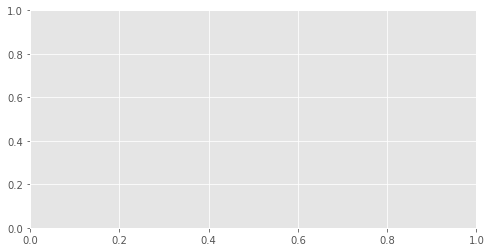

In [6]:
plot_stats_in_graph(total_losses)